In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import sys
sys.path.append("../../../../../src/")
import nanonets_utils
import nanonets

plt.style.use(["science","bright","grid"])

from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def sin_func(t, A, f0, phi, B):
    return A*np.sin(2*np.pi*f0*t-phi) + B

def exp_decay(x, a, b, c):
    return a*np.exp(-x/b) + c

In [2]:
# Global
stat_size   = 100
N_periods   = 40
N_p         = 9
folder      = "/home/j/j_mens07/phd/data/2_funding_period/"
f0          = 1.0*1e6
f1          = 3.0*1e6
dt          = 1/(20 * f1)
T_sim       = N_periods/f0
N_voltages  = int(T_sim/dt)

# 8 Electrodes
topology_parameter  = {
    "Nx"                : N_p,
    "Ny"                : N_p,
    "Nz"                : 1,
    "e_pos"             : [[(N_p-1)//2,0,0],[0,0,0],[N_p-1,0,0],
                        [0,(N_p-1)//2,0],[N_p-1,(N_p-1)//2,0],
                        [0,N_p-1,0],[N_p-1,N_p-1,0],[(N_p-1)//2,N_p-1,0]],
    "electrode_type"    : ['constant','constant','constant','constant',
                        'constant','constant','constant','floating']
}

In [3]:
frequencies         = [0.0,f0,f1,0.0,0.0,0.0,0.0,0.0]
amplitudes          = [0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0]
offsets             = []
time_steps, volt    = nanonets_utils.sinusoidal_voltages(N_voltages, topology_parameter,amplitudes=amplitudes,frequencies=frequencies,time_step=dt)

In [4]:
data    = {}
N_cols  = 500
for i in range(N_cols):
    data[i] = pd.read_csv(folder+f"potential/magic_cable/ac_two_tone_signal/Nx=9_Ny=9_Nz=1_Ne=8_{i}.csv")
N_rows  = len(data[0])
start   = 500
arr_tmp = np.zeros((N_rows,N_cols))
for i in range(N_cols):
    arr_tmp[:,i] = data[i]['Current'].values*1000

arr = arr_tmp.copy()[start:,:]

In [12]:
f_vals  = [f1-3*f0, f1-2*f0, f1-f0, f1+f0, f1+2*f0, f1+3*f0, f1+4*f0, 2*f1+f0]
h_dist  = []

for i in range(N_cols):
    y_val   = arr[:,i].copy()
    y_val   = y_val - np.mean(y_val)
    xf, yf  = nanonets_utils.fft(y_val, dt=dt, n_padded=len(y_val)*10)
    func    = interp1d(xf, yf)
    yf0     = func(f0)
    yf1     = func(f1)
    y_in    = (yf0+yf1)/2
    y_out   = func(f_vals)/y_in
    h_dist.append(y_out)

harmonic_dist   = pd.DataFrame(h_dist)
thd_vals        = np.sqrt((pd.DataFrame(h_dist)**2).sum(axis=1)).values
min_index       = np.argmin(thd_vals)
max_index       = np.argmax(thd_vals)
sort_index      = np.argsort(thd_vals)
df_min          = pd.read_csv(f"{folder}potential/magic_cable/ac_two_tone_signal/Nx=9_Ny=9_Nz=1_Ne=8_{min_index}.csv")
df_max          = pd.read_csv(f"{folder}potential/magic_cable/ac_two_tone_signal/Nx=9_Ny=9_Nz=1_Ne=8_{max_index}.csv")

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, '$f_1 - 3 \\cdot f_0$'),
  Text(0, 1.5, '$f_1 - 2 \\cdot f_0$'),
  Text(0, 2.5, '$f_1 - f_0$'),
  Text(0, 3.5, '$f_1 + f_0$'),
  Text(0, 4.5, '$f_1 + 2 \\cdot f_0$'),
  Text(0, 5.5, '$f_1 + 3 \\cdot f_0$'),
  Text(0, 6.5, '$f_1 + 4 \\cdot f_0$'),
  Text(0, 7.5, '$2 \\cdot f_1 + f_0$')])

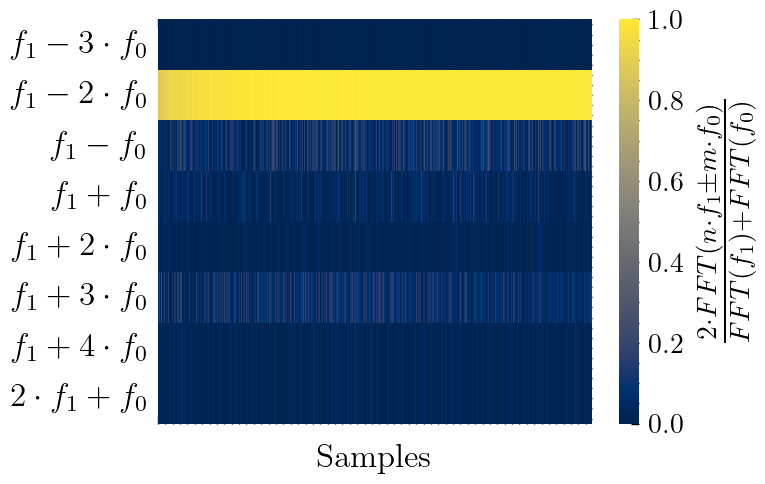

In [17]:
y_labels    = ["$f_1 - 3 \cdot f_0$",
               "$f_1 - 2 \cdot f_0$",
               "$f_1 - f_0$",
               "$f_1 + f_0$",
               "$f_1 + 2 \cdot f_0$",
               "$f_1 + 3 \cdot f_0$",
               "$f_1 + 4 \cdot f_0$",
               "$2 \cdot f_1 + f_0$"]
fig         = plt.figure(dpi=200)
ax          = fig.add_subplot()
ax          = sns.heatmap(harmonic_dist.iloc[sort_index,:].reset_index(drop=True).T, vmin=0, vmax=1.0, cmap='cividis', ax=ax)
ax.figure.axes[-1].set_ylabel('$\\frac{2 \cdot FFT(n \cdot f_1 \pm m \cdot f_0)}{FFT(f_1)+FFT(f_0)}$', size='x-large')
ax.set_xticklabels("")
ax.set_xlabel("Samples", size='large')
ax.set_yticklabels(y_labels, size='large')
plt.yticks(rotation=0)

# fig.savefig("../plots/frequency/sample_overview.svg", transparent=True, bbox_inches='tight')
# fig.savefig("../plots/frequency/sample_overview.pdf", transparent=False, bbox_inches='tight')

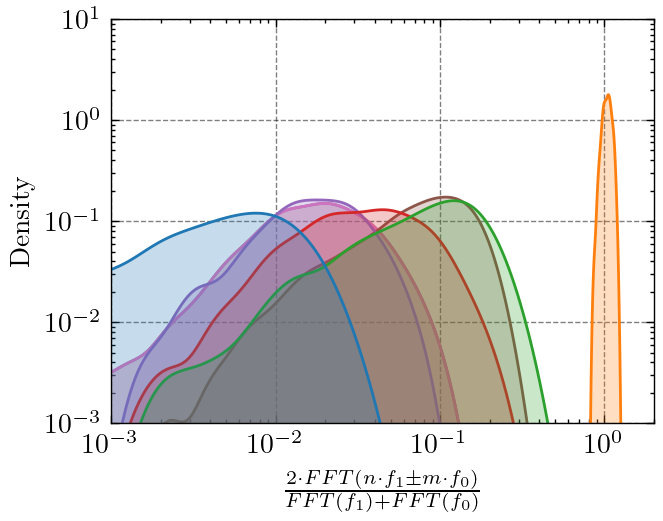

In [80]:
h_kde           = harmonic_dist.copy()
h_kde.columns   = y_labels

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.kdeplot(h_kde, log_scale=True, palette='tab10', legend=False, bw_adjust=1, fill=True)

ax.set_xlim(1e-3,2e0)
ax.set_xlabel('$\\frac{2 \cdot FFT(n \cdot f_1 \pm m \cdot f_0)}{FFT(f_1)+FFT(f_0)}$')
ax.set_ylim(1e-3,1e1)
ax.set_yscale('log')

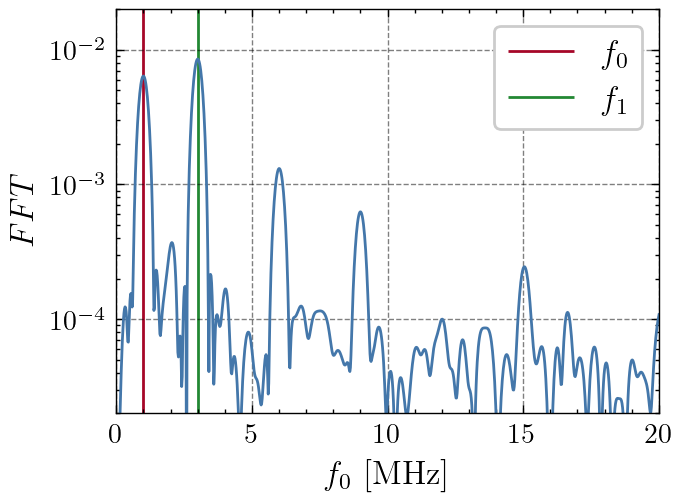

In [62]:
ymin    = 2e-5
ymax    = 2e-2
arr     = df_min['Current'].values[start:]
arr     = arr - np.mean(arr)
xf, yf  = nanonets_utils.fft(arr, dt=dt, n_padded=len(arr)*10)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(xf/1e6, yf)
ax.vlines(f0/1e6,ymin,ymax,colors=nanonets_utils.red_color, label='$f_0$', zorder=0)
ax.vlines(f1/1e6,ymin,ymax,colors=nanonets_utils.green_color, label='$f_1$', zorder=0)
ax.set_xlim(0,20)
ax.set_yscale('log')
ax.set_ylim(ymin,ymax)
ax.set_ylabel("$FFT$", size='large')
ax.set_xlabel("$f_0$ [MHz]", size='large')
ax.legend(fontsize='large')

# fig.savefig("../plots/frequency/fft_minimum_distorition.svg", transparent=True, bbox_inches='tight')
# fig.savefig("../plots/frequency/fft_minimum_distorition.pdf", transparent=False, bbox_inches='tight')

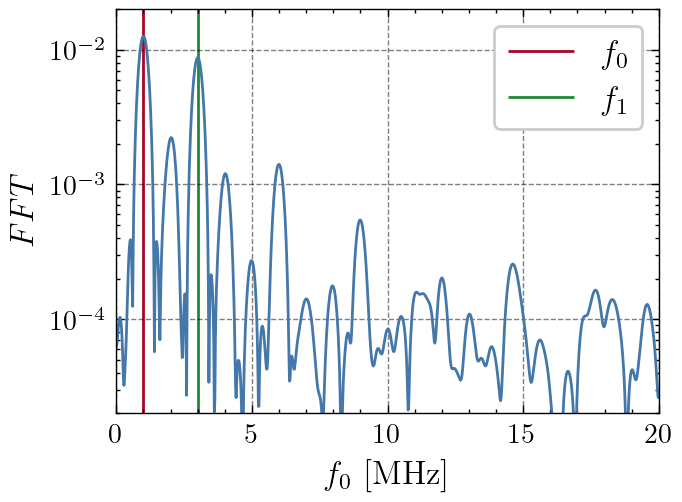

In [63]:
ymin    = 2e-5
ymax    = 2e-2
arr     = df_max['Current'].values[start:]
arr     = arr - np.mean(arr)
xf, yf  = nanonets_utils.fft(arr, dt=dt, n_padded=len(arr)*10)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(xf/1e6, yf)
ax.vlines(f0/1e6,ymin,ymax,colors=nanonets_utils.red_color, label='$f_0$', zorder=0)
ax.vlines(f1/1e6,ymin,ymax,colors=nanonets_utils.green_color, label='$f_1$', zorder=0)
ax.set_xlim(0,20)
ax.set_yscale('log')
ax.set_ylim(ymin,ymax)
ax.set_ylabel("$FFT$", size='large')
ax.set_xlabel("$f_0$ [MHz]", size='large')
ax.legend(fontsize='large')

# fig.savefig("../plots/frequency/fft_maximum_distorition.svg", transparent=True, bbox_inches='tight')
# fig.savefig("../plots/frequency/fft_maximum_distorition.pdf", transparent=False, bbox_inches='tight')